In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
bdi2_df = pd.read_csv('../data/bdi_2.csv')

C:\Users\juan_\AppData\Local\Temp\ipykernel_193136\3168847921.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  bdi2_df = pd.read_csv('../data/bdi_2.csv')


In [3]:
bdi3_df = pd.read_excel('../data/bdi_3.xlsx')

In [4]:
eco_df = pd.read_excel('../data/eco.xlsx', sheet_name="ECO with Exit23-24 ")

In [5]:
bdi2_df['testDate'] = pd.to_datetime(bdi2_df['testDate'])


In [6]:
bdi3_df['Adaptive-Self Care Date of Testing'] = pd.to_datetime(bdi3_df['Adaptive-Self Care Date of Testing'])

In [14]:
entry_exit = eco_df[(eco_df['OC1 Data Check']==1)][['CHILD_ID','BDI 3\nECO_Entry_DATE','BDI 3\nECO_Exit_DATE','BDI2 Entry Date']]

entry_exit.rename(columns={'CHILD_ID':'TEIDS Child ID'}, inplace=True)

entry_exit = entry_exit[(entry_exit['BDI 3\nECO_Exit_DATE'].notnull())&((entry_exit['BDI 3\nECO_Entry_DATE'].notnull())|(entry_exit['BDI2 Entry Date'].notnull()))]

In [18]:
bdi3_exit = entry_exit.merge(bdi3_df,how='inner',left_on=['TEIDS Child ID','BDI 3\nECO_Exit_DATE'],right_on=['TEIDS Child ID','Adaptive-Self Care Date of Testing'])

bdi3_entry = entry_exit.merge(bdi3_df,how='inner',left_on=['TEIDS Child ID','BDI 3\nECO_Entry_DATE'],right_on=['TEIDS Child ID','Adaptive-Self Care Date of Testing'])

bdi2_entry_subdomains = entry_exit.merge(bdi2_df,how='inner',left_on=['TEIDS Child ID','BDI2 Entry Date'],right_on=['Student TEIDS ID','testDate'])

bdi2_entry_subdomains = bdi2_entry_subdomains[~bdi2_entry_subdomains['testDate'].isnull()]

bdi2_entry = bdi2_df[bdi2_df['studentAssessmentID'].isin(bdi2_entry_subdomains['studentAssessmentID'])]

bdi2_entry['Student TEIDS ID'] = bdi2_entry['Student TEIDS ID'].astype('int64')

bdi3_entry = bdi3_entry[~bdi3_entry['Adaptive-Self Care Date of Testing'].isnull()]

bdi2_entry = bdi2_entry[['Student TEIDS ID','domainText','rawScore','DQScore','ZScore']]

bdi3_entry = bdi3_entry[['TEIDS Child ID','Adaptive Developmental Quotient','Social-Emotional Developmental Quotient','Communication Developmental Quotient','Motor Developmental Quotient','Cognitive Developmental Quotient','Adaptive-Self Care RS','Adaptive-Self Care Z-Score','Adaptive-Personal Responsibility RS','Adaptive-Personal Responsibility Z-Score','Social Emotional-Adult Interaction RS','Social Emotional-Adult Interaction Z-Score','Social Emotional-Peer Interaction RS','Social Emotional-Peer Interaction Z-Score','Social Emotional-Self Concept / Social Role RS','Social Emotional-Self Concept / Social Role Z-Score','Communication-Receptive Communication RS','Communication-Receptive Communication Z-Score','Communication-Expressive Communication RS','Communication-Expressive Communication Z-Score','Motor-Gross Motor RS','Motor-Gross Motor Z-Score','Motor-Fine Motor RS','Motor-Fine Motor Z-Score','Motor-Perceptual Motor RS','Motor-Perceptual Motor Z-Score','Cognitive-Attention and Memory RS','Cognitive-Attention and Memory Z-Score','Cognitive-Reasoning / Academic Skills RS','Cognitive-Reasoning / Academic Skills Z-Score','Cognitive-Perception and Concepts RS','Cognitive-Perception and Concepts Z-Score']]

bdi3_exit = bdi3_exit[['TEIDS Child ID','Adaptive Developmental Quotient','Social-Emotional Developmental Quotient','Communication Developmental Quotient','Motor Developmental Quotient','Cognitive Developmental Quotient','Adaptive-Self Care RS','Adaptive-Self Care Z-Score','Adaptive-Personal Responsibility RS','Adaptive-Personal Responsibility Z-Score','Social Emotional-Adult Interaction RS','Social Emotional-Adult Interaction Z-Score','Social Emotional-Peer Interaction RS','Social Emotional-Peer Interaction Z-Score','Social Emotional-Self Concept / Social Role RS','Social Emotional-Self Concept / Social Role Z-Score','Communication-Receptive Communication RS','Communication-Receptive Communication Z-Score','Communication-Expressive Communication RS','Communication-Expressive Communication Z-Score','Motor-Gross Motor RS','Motor-Gross Motor Z-Score','Motor-Fine Motor RS','Motor-Fine Motor Z-Score','Motor-Perceptual Motor RS','Motor-Perceptual Motor Z-Score','Cognitive-Attention and Memory RS','Cognitive-Attention and Memory Z-Score','Cognitive-Reasoning / Academic Skills RS','Cognitive-Reasoning / Academic Skills Z-Score','Cognitive-Perception and Concepts RS','Cognitive-Perception and Concepts Z-Score']]

C:\Users\juan_\AppData\Local\Temp\ipykernel_193136\3986738503.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi2_entry['Student TEIDS ID'] = bdi2_entry['Student TEIDS ID'].astype('int64')


In [20]:
def transform_data(file)-> pd.DataFrame:
    df = file #This was originally where you would read in the csv for bdi-2, I changed it to run the already filtered dataframe -- Ryan
        #drop null student ID if you have any
    df = df[~df['Student TEIDS ID'].isnull()]
    # there are ids that have mulitple duplicate IDs example:526857
    #the following code will help deal with duplciate domain - allowing us to create more that 1 row if it has dup domain text
    df = df.sort_values(['Student TEIDS ID','domainText']).reset_index(drop=True)
    #sequential number to each row within a group
    df['row_number'] = df.groupby(['Student TEIDS ID', 'domainText']).cumcount()
    #pivot dataframe
    df_pivot = df.pivot_table(index=['Student TEIDS ID', 'row_number']
              , columns='domainText'
              , values=['rawScore','DQScore','ZScore']
              , aggfunc='first')
    #flatten multi-index columns
    df_pivot.columns = [f"{col[1]}-{col[0]}" for col in df_pivot.columns]
    #reset index
    df_pivot = df_pivot.reset_index()
    #drop row number
    df_pivot = df_pivot.drop(columns=['row_number'])
    return df_pivot

In [22]:
bdi2_df_test = transform_data(bdi2_entry)
bdi2_df_test

,Student TEIDS ID,Adaptive-DQScore,Cognitive-DQScore,Communication-DQScore,Motor-DQScore,Personal-Social-DQScore,Adaptive-ZScore,Adult Interaction-ZScore,Attention and Memory-ZScore,Cognitive-ZScore,...,Motor-rawScore,Peer Interaction-rawScore,Perception and Concepts-rawScore,Perceptual Motor-rawScore,Personal Responsibility-rawScore,Personal-Social-rawScore,Reasoning and Academic Skills-rawScore,Receptive Communication-rawScore,Self-Care-rawScore,Self-Concept and Social Role-rawScore
0,474848,75.0,63.0,55.0,90.0,70.0,-1.67,-2.00,-1.67,-2.47,...,77.0,NaN,8.0,NaN,NaN,33.0,NaN,11.0,23.0,10.0
1,474967,80.0,80.0,73.0,70.0,78.0,-1.33,-0.33,-2.00,-1.33,...,2.0,NaN,4.0,NaN,NaN,5.0,NaN,2.0,2.0,0.0
2,475907,90.0,73.0,78.0,85.0,85.0,-0.67,-0.67,-2.67,-1.80,...,5.0,NaN,4.0,NaN,NaN,6.0,NaN,6.0,3.0,2.0
3,476193,100.0,83.0,75.0,93.0,88.0,0.00,0.00,-1.33,-1.13,...,9.0,NaN,4.0,NaN,NaN,9.0,NaN,7.0,4.0,2.0
4,478004,85.0,73.0,75.0,80.0,80.0,-1.00,-1.33,-3.00,-1.80,...,7.0,NaN,6.0,NaN,NaN,7.0,NaN,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,543275,85.0,82.0,63.0,105.0,87.0,-1.00,0.00,-0.67,-1.20,...,112.0,12.0,16.0,18.0,6.0,88.0,10.0,25.0,36.0,30.0
2555,543279,80.0,80.0,56.0,93.0,78.0,-1.33,-1.67,-1.33,-1.33,...,82.0,NaN,13.0,NaN,NaN,44.0,NaN,17.0,26.0,17.0
2556,543285,80.0,77.0,75.0,91.0,82.0,-1.33,-1.33,-1.00,-1.53,...,97.0,7.0,10.0,10.0,4.0,62.0,8.0,24.0,28.0,22.0
2557,543286,65.0,73.0,57.0,83.0,73.0,-2.33,-2.00,-1.67,-1.80,...,74.0,NaN,12.0,NaN,NaN,40.0,NaN,14.0,22.0,14.0


In [24]:
test_ids = bdi3_exit[(bdi3_exit['TEIDS Child ID'].isin(bdi3_entry['TEIDS Child ID']))|(bdi3_exit['TEIDS Child ID'].isin(bdi2_entry['Student TEIDS ID']))]['TEIDS Child ID']

test_ids

bdi2_flag = pd.DataFrame({'TEIDS Child ID':bdi2_entry['Student TEIDS ID'].unique()})
bdi2_flag['bdi_flag'] = 2

bdi3_flag = pd.DataFrame(bdi3_entry['TEIDS Child ID'])
bdi3_flag['bdi_flag'] = 3

entry_flag = bdi2_flag.merge(bdi3_flag,how='outer',left_on=['TEIDS Child ID','bdi_flag'],right_on=['TEIDS Child ID','bdi_flag'])

In [26]:
exit_flagged = entry_flag.merge(bdi3_exit,how='inner',on='TEIDS Child ID')

bdi2_entry_exit = exit_flagged[exit_flagged['bdi_flag']==2]

bdi3_entry_exit = exit_flagged[exit_flagged['bdi_flag']==3]

In [28]:
bdi3_merge = bdi3_entry.merge(bdi3_entry_exit,how='inner',on='TEIDS Child ID',suffixes=("_entry","_exit"))

bdi3_oc1_e = bdi3_merge[(bdi3_merge['Social-Emotional Developmental Quotient_entry']>=78)
    &(bdi3_merge['Social Emotional-Adult Interaction Z-Score_entry']>-1.5)
    &(bdi3_merge['Social Emotional-Self Concept / Social Role Z-Score_entry']>-1.5)
    &(bdi3_merge['Social Emotional-Peer Interaction Z-Score_entry']>-1.5)]

bdi3_oc1 = ['TEIDS Child ID','Social-Emotional Developmental Quotient_entry','Social-Emotional Developmental Quotient_exit','Social Emotional-Adult Interaction Z-Score_entry','Social Emotional-Adult Interaction Z-Score_exit','Social Emotional-Self Concept / Social Role Z-Score_entry','Social Emotional-Self Concept / Social Role Z-Score_exit','Social Emotional-Peer Interaction Z-Score_entry','Social Emotional-Peer Interaction Z-Score_exit','Social Emotional-Adult Interaction RS_entry','Social Emotional-Adult Interaction RS_exit','Social Emotional-Peer Interaction RS_entry','Social Emotional-Peer Interaction RS_exit','Social Emotional-Self Concept / Social Role RS_entry','Social Emotional-Self Concept / Social Role RS_exit']

bdi3_oc1_d = bdi3_merge[((bdi3_merge['Social-Emotional Developmental Quotient_entry']<78)&(bdi3_merge['Social-Emotional Developmental Quotient_exit']>=78))
    |(((bdi3_merge['Social-Emotional Developmental Quotient_entry']>=78)&(bdi3_merge['Social-Emotional Developmental Quotient_exit']>=78))
      &((bdi3_merge['Social Emotional-Adult Interaction Z-Score_entry']<=-1.5)
        |(bdi3_merge['Social Emotional-Adult Interaction Z-Score_exit']<=-1.5)
        |(bdi3_merge['Social Emotional-Self Concept / Social Role Z-Score_entry']<=-1.5)
        |(bdi3_merge['Social Emotional-Self Concept / Social Role Z-Score_exit']<=-1.5)
        |(bdi3_merge['Social Emotional-Peer Interaction Z-Score_entry']<=-1.5)
        |(bdi3_merge['Social Emotional-Peer Interaction Z-Score_exit']<=-1.5)))]

bdi3_oc1_c = bdi3_merge[((bdi3_merge['Social-Emotional Developmental Quotient_entry']<bdi3_merge['Social-Emotional Developmental Quotient_exit'])
                         &(bdi3_merge['Social-Emotional Developmental Quotient_exit']<78))
    &((bdi3_merge['Social Emotional-Adult Interaction RS_exit']>bdi3_merge['Social Emotional-Adult Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Peer Interaction RS_exit']>bdi3_merge['Social Emotional-Peer Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Self Concept / Social Role RS_exit']>bdi3_merge['Social Emotional-Self Concept / Social Role RS_entry']))]

bdi3_oc1_b = bdi3_merge[((bdi3_merge['Social-Emotional Developmental Quotient_entry']>=bdi3_merge['Social-Emotional Developmental Quotient_exit'])
                         &(bdi3_merge['Social-Emotional Developmental Quotient_exit']<78))
    &((bdi3_merge['Social Emotional-Adult Interaction RS_exit']>bdi3_merge['Social Emotional-Adult Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Peer Interaction RS_exit']>bdi3_merge['Social Emotional-Peer Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Self Concept / Social Role RS_exit']>bdi3_merge['Social Emotional-Self Concept / Social Role RS_entry']))]

bdi3_oc1_a = bdi3_merge[(bdi3_merge['Social-Emotional Developmental Quotient_exit']<78)
    &(bdi3_merge['Social Emotional-Adult Interaction RS_exit']<=bdi3_merge['Social Emotional-Adult Interaction RS_entry'])
    &(bdi3_merge['Social Emotional-Peer Interaction RS_exit']<=bdi3_merge['Social Emotional-Peer Interaction RS_entry'])
    &(bdi3_merge['Social Emotional-Self Concept / Social Role RS_exit']<=bdi3_merge['Social Emotional-Self Concept / Social Role RS_entry'])]

In [30]:
aid3 = bdi3_oc1_a['TEIDS Child ID']

In [96]:
time_in_program = eco_df[['CHILD_ID','Days btw Initial and Exit','Days btw I-IFSP to Exit ECO','<Calc> Entrance Age (months)']]
time_in_program = time_in_program[time_in_program['Days btw Initial and Exit'] > 181]
time_in_program.loc[:, 'Years btw Initial and Exit'] = time_in_program['Days btw Initial and Exit'] / 365.2422
time_in_program.loc[:, 'Years btw I-IFSP to Exit ECO'] = time_in_program['Days btw I-IFSP to Exit ECO'] / 365.2422
time_in_program.loc[:, 'Age upon Exit (years)'] = (
    (time_in_program['<Calc> Entrance Age (months)']/12) + time_in_program['Years btw Initial and Exit']
)

exit_age = time_in_program[['CHILD_ID','Age upon Exit (years)']]

exit_age_a = exit_age[exit_age['CHILD_ID'].isin(aid3)]

exit_age_sorted = exit_age_a.sort_values(by='Age upon Exit (years)', ascending=False)

exit_age_sorted

,CHILD_ID,Age upon Exit (years)
1360,505750,5.990993
3215,526656,5.956755
6617,548484,5.076344
6429,546876,5.045031
6691,549176,4.951596
6706,549286,4.885036
6896,551084,4.789209
6245,545247,4.782883
7086,552972,4.746945
5792,542136,4.595510


In [48]:
exit_age_sorted['Age upon Exit (years)'].describe()

count    51.000000
mean      4.187004
std       0.562327
min       3.498299
25%       3.809650
50%       3.914116
75%       4.482657
max       5.990993
Name: Age upon Exit (years), dtype: float64

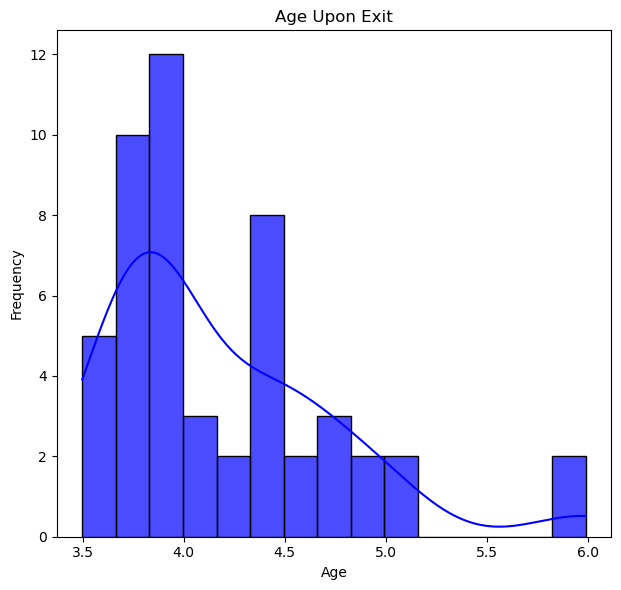

In [52]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(exit_age_sorted['Age upon Exit (years)'], bins=15, kde=True, color='blue', alpha=0.7)
plt.title('Age Upon Exit')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [36]:
bdi3_eco_a = eco_df[eco_df['CHILD_ID'].isin(aid3)]

bdi3_eco_a['length_between_assessment'] = bdi3_eco_a['ECO_Exit_DATE'] - bdi3_eco_a['ECO_Entry_DATE']

bdi3_eco_diff = bdi3_eco_a[['CHILD_ID','length_between_assessment']]

bdi3_eco_diff = bdi3_eco_diff[bdi3_eco_diff['length_between_assessment'].dt.days>181]

C:\Users\juan_\AppData\Local\Temp\ipykernel_193136\2485871645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi3_eco_a['length_between_assessment'] = bdi3_eco_a['ECO_Exit_DATE'] - bdi3_eco_a['ECO_Entry_DATE']


In [92]:
# BDI3 - Category A - Time between between entry and exit assessments
bdi3_eco_diff = bdi3_eco_diff.sort_values(by='length_between_assessment', ascending=False)
bdi3_eco_diff.head()

,CHILD_ID,length_between_assessment
1360,505750,715 days
3215,526656,668 days
6706,549286,401 days
5792,542136,395 days
6245,545247,377 days


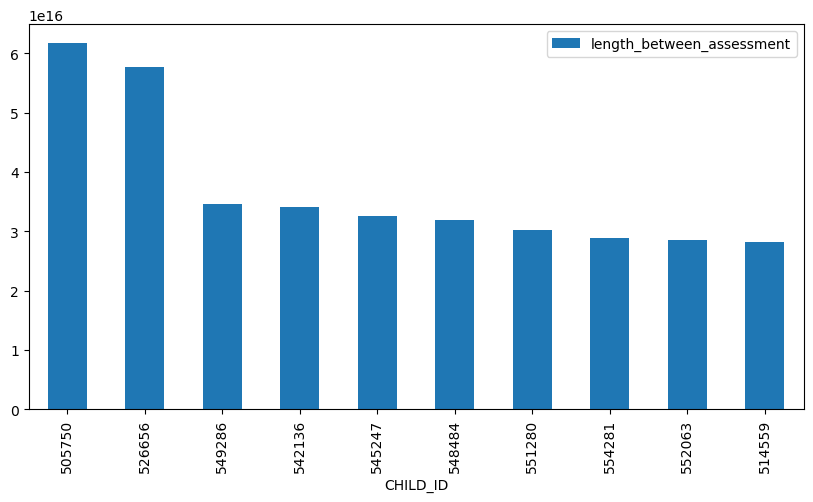

In [88]:
bdi3_eco_diff.head(10).plot(kind='bar',
              x='CHILD_ID',
              y='length_between_assessment',
              figsize=(10,5));

In [40]:
bdi3_a_tip = time_in_program[time_in_program['CHILD_ID'].isin(aid3)]
bdi3_a_tip = bdi3_a_tip[['CHILD_ID','Days btw Initial and Exit']]
bdi3_a_tip = bdi3_a_tip.sort_values(by='Days btw Initial and Exit', ascending=False)

In [44]:
# BDI3 - Category A - Time between entry and exit
bdi3_a_tip.head()

,CHILD_ID,Days btw Initial and Exit
1360,505750,1062
3215,526656,806
6245,545247,499
6429,546876,473
5792,542136,461


In [106]:
outcome_1 = pd.read_csv('../data/outcome1_a.csv')

In [108]:
outcome_2 = pd.read_csv('../data/outcome2_a.csv')

In [110]:
outcome_3 = pd.read_csv('../data/outcome3_a.csv')

In [112]:
pc_a = pd.concat([outcome_1, outcome_2, outcome_3], ignore_index=True)

id3 = pc_a['Student TEIDS ID']

In [116]:
pc_a


,Unnamed: 0,Student TEIDS ID,USE_ENTRANCE_DQScore_Adaptive,USE_ENTRANCE_DQScore_Cognitive,USE_ENTRANCE_DQScore_Communication,USE_ENTRANCE_DQScore_Motor,USE_ENTRANCE_DQScore_Social,USE_ENTRANCE_ZScore_Adaptive,USE_ENTRANCE_ZScore_Adaptive-Self_Care,USE_ENTRANCE_ZScore_Adaptive-Personal_Responsibility,...,EXIT_Cognitive-Perception and Concepts Z-Score,EXIT_Cognitive-Perception and Concepts T-Score,EXIT_Cognitive-Perception and Concepts NCE,social_category,adaptive_category,outcome2_entrance_DQ,outcome2_exit_DQ,outcome2_subdomain_check,outcome2_category,outcome3_category
0,6,486067,93.0,74.0,75.0,77.0,77.0,-0.47,-1.00,0.00,...,1.00,40.0,29,a,a,NaN,NaN,NaN,NaN,NaN
1,13,490309,88.0,65.0,55.0,66.0,88.0,-0.80,-2.33,0.67,...,3.00,20.0,<1,a,a,NaN,NaN,NaN,NaN,NaN
2,502,520001,95.0,83.0,65.0,85.0,95.0,-0.33,-0.33,-0.33,...,3.00,20.0,<1,a,a,NaN,NaN,NaN,NaN,NaN
3,544,522186,60.0,58.0,55.0,73.0,83.0,-2.67,-2.67,0.00,...,2.00,30.0,8,a,a,NaN,NaN,NaN,NaN,NaN
4,613,523762,55.0,67.0,55.0,63.0,75.0,-3.00,-3.00,0.00,...,3.00,20.0,<1,a,b,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,3141,550727,103.0,70.0,46.0,87.0,92.0,0.20,0.00,0.33,...,3.00,20.0,<1,NaN,NaN,58.0,54.0,Yes,b,a
163,3189,551280,82.0,80.0,55.0,81.0,80.0,1.20,1.33,0.67,...,3.00,20.0,<1,NaN,NaN,67.5,55.0,Yes,b,a
164,3297,552972,76.0,80.0,46.0,85.0,92.0,1.60,1.67,1.00,...,2.67,23.0,<1,NaN,NaN,63.0,57.0,Yes,b,a
165,3298,552984,91.0,84.0,70.0,87.0,98.0,0.60,1.00,0.00,...,1.67,33.0,15,NaN,NaN,77.0,61.0,Yes,b,a
